In [93]:
import sys
import os
import os.path as op
# from dipy.io.image import load_nifti
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
import torchio as tio
import numpy as np
# import pytorch_lightning as pl
import pandas as pd
import seaborn as sns
import re
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter
from torch import nn
import segmentation_models_pytorch.utils as smpu
import segmentation_models_pytorch

%matplotlib inline

In [94]:
import sys
import torch
from tqdm import tqdm as tqdm
from segmentation_models_pytorch.utils.meter import AverageValueMeter


# adaptions made to the classes from segmentation models
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True, unet2d=False):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

        self.unet2d = unet2d

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
                dataloader,
                desc=self.stage_name,
                file=sys.stdout,
                disable=not (self.verbose),
        ) as iterator:
            for data in iterator:
                x = data['img']['data']
                y = data['label']['data']
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, device="cpu", verbose=True, unet2d=False):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
            unet2d=unet2d
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        if self.unet2d is True:
            batch_size = x.shape[0]
            o_shape = x.shape
            x = x.reshape(batch_size, 1, 160, -1)

            prediction = self.model.forward(x).reshape(o_shape)
        else:
            prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True, unet2d=False):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
            unet2d=unet2d
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            if self.unet2d is True:
                batch_size = x.shape[0]
                o_shape = x.shape
                x = x.reshape(batch_size, 1, 160, -1)

                prediction = self.model.forward(x).reshape(o_shape)
            else:
                prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, new_loss, old_loss):
        if (new_loss - old_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [95]:
class JaccardIndex(nn.Module):
    __name__ = "iou_score"
    
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, pred, y):
        n_classes = pred.size()[1]
        assert pred.size() == y.size()

        per_batch_iou = []
        for _input, _target in zip(pred, y):
            binary_prediction = self._binarize_predictions(_input, n_classes)

            # convert to uint8 just in case
            binary_prediction = binary_prediction.byte()
            _target = _target.byte()

            per_channel_iou = []
            for c in range(n_classes):
                per_channel_iou.append(self._jaccard_index(binary_prediction[c], _target[c]))

            assert per_channel_iou, "All channels were ignored from the computation"
            mean_iou = torch.mean(torch.tensor(per_channel_iou))
            per_batch_iou.append(mean_iou)

        return torch.mean(torch.tensor(per_batch_iou))

    def _binarize_predictions(self, y, n_classes):
        """
        Puts 1 for the class/channel with the highest probability and 0 in other channels. Returns byte tensor of the
        same size as the input tensor.
        """
        if n_classes == 1:
            # for single channel input just threshold the probability map
            result = y > 0.5
            return result.long()

        _, max_index = torch.max(y, dim=0, keepdim=True)
        return torch.zeros_like(y, dtype=torch.uint8).scatter_(0, max_index, 1)

    def _jaccard_index(self, prediction, target):
        """
        Computes IoU for a given target and prediction tensors
        """
        return torch.sum(prediction & target).float() / torch.clamp(torch.sum(prediction | target).float(), min=1e-8)

In [96]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(np.swapaxes(image, 0, 1))
    plt.show()

In [97]:
from torch.utils.data import Dataset

class SpinalCordDataset(Dataset):
    def __init__(self, annotations_files, img_files, transform=None, target_transform=None):
        self.img_labels = annotations_files
        self.img_files = img_files
        self.transform = transform
        self.target_transform = target_transform
        self.history_transforms = {}
        for idx in range(len(self.img_files)):
            self.history_transforms[idx] = self.transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        image = img_file.data
        label = self.img_labels[idx].data
        if self.transform:
            image = self.history_transforms[idx](image)#.reshape(1,160,-1)
        if self.target_transform:
            label = self.target_transform(label)#.reshape(1,160,-1)
        return image, label

In [98]:
subjects = []
cop = tio.CropOrPad((144, 48, 32))

lumbar = Path(op.join(sys.path[0], 'dataset/Lumbar'))

for file_path in lumbar.iterdir():
    for image in file_path.rglob('*mean.nii.gz'):
        image = tio.ScalarImage(image)
    for label in file_path.rglob('*sc.nii.gz'):
        label = tio.ScalarImage(label)
        
    subjects.append(tio.Subject(img=cop(image), label=cop(label), shape=[image.shape]))

In [99]:
lumbar = tio.SubjectsDataset(subjects)
test_lumbar = DataLoader(lumbar, batch_size=1, shuffle=True)

In [100]:
image_files = []
image_labels = []

single_imgs = Path(op.join(sys.path[0], 'dataset/Experiment4/sub-02/single_images'))

for file in single_imgs.iterdir():
    image_files.append(tio.ScalarImage(file))

# get index of the fmri volume and add the corresponding mask in the same order
regex = re.compile(r'\d+')
for img in image_files:
    idx = [int(x) for x in regex.findall(str(img.path))][2]
    if idx in [0, 2, 3, 225]:
        label_path = op.join(sys.path[0], f'dataset/Experiment4/sub-02/mask_sc_vol{idx}.nii.gz')
    else:
        label_path = op.join(sys.path[0], 'dataset/Experiment4/sub-02/mask_sc.nii.gz')
    image_labels.append(tio.LabelMap(label_path))

In [101]:
dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((160, 64, 48)), tio.CropOrPad((160, 64, 48)))

In [102]:
test_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [103]:
loss = smpu.losses.DiceLoss()
metrics = [
    JaccardIndex(),
]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
created_model = torch.load('../../output3d2/unet3d.pth', map_location=torch.device('cpu'))

In [ ]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

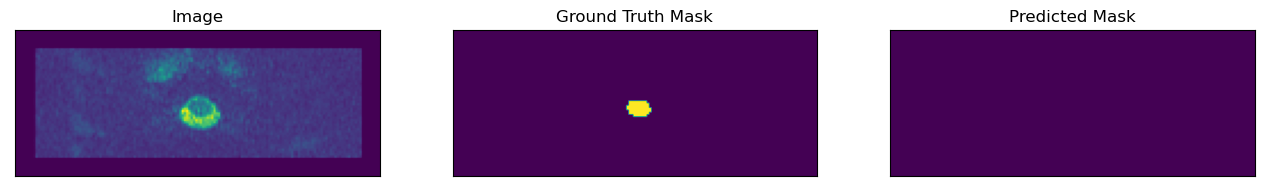

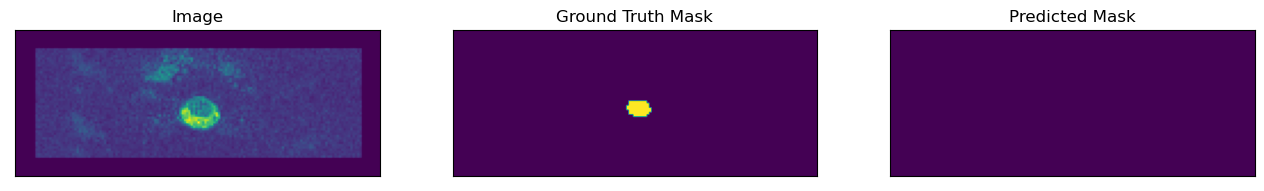

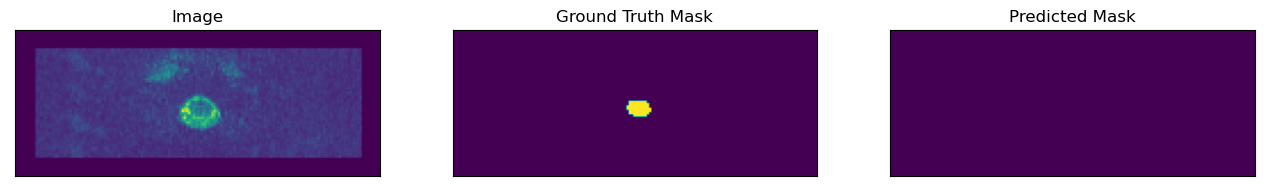

In [16]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(160, 64, 48)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(160,64,48)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160,64,48)
#     pr_mask[pr_mask < value] = 0
#     pr_mask[pr_mask > value] = 1
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

Let's try the reduced 3d UNet

In [17]:
created_model = torch.load('../../outputreduced3d/vnet3d_best.pth', map_location=torch.device('cpu'))

In [9]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid:   6%| | 5/90 [01:04<18:23, 12.99s/it, dice_loss - 0.5284, iou_score - 0.3


KeyboardInterrupt: 

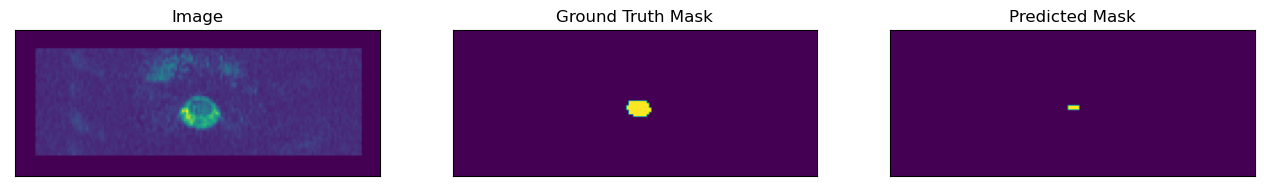

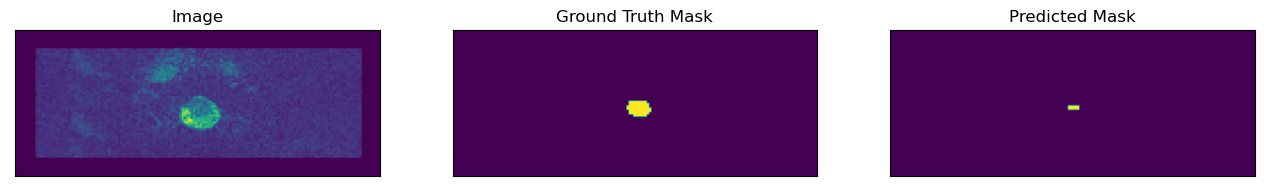

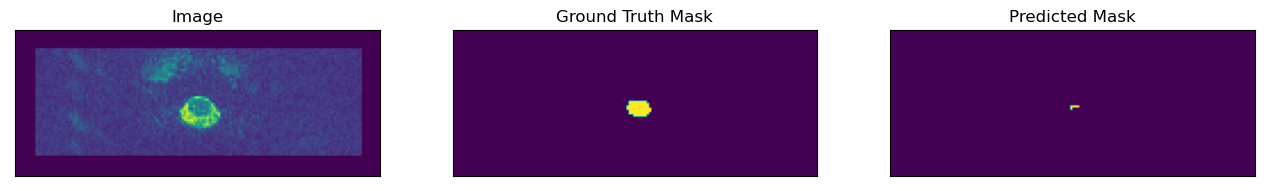

In [19]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(160, 64, 48)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(160, 64, 48)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160, 64, 48)
#     pr_mask[pr_mask < value] = 0
#     pr_mask[pr_mask > value] = 1
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

some Vnets

In [9]:
created_model = torch.load('../../outputvnet/vnet3d.pth', map_location=torch.device('cpu'))

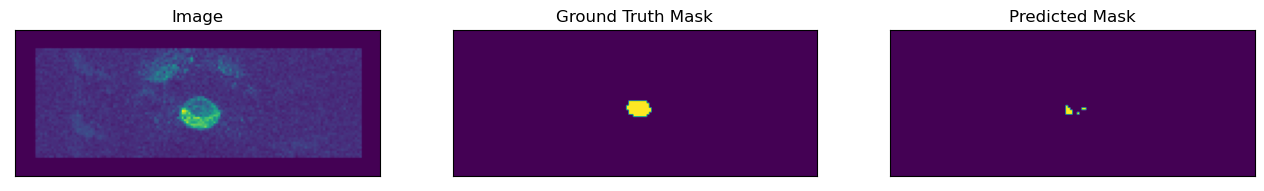

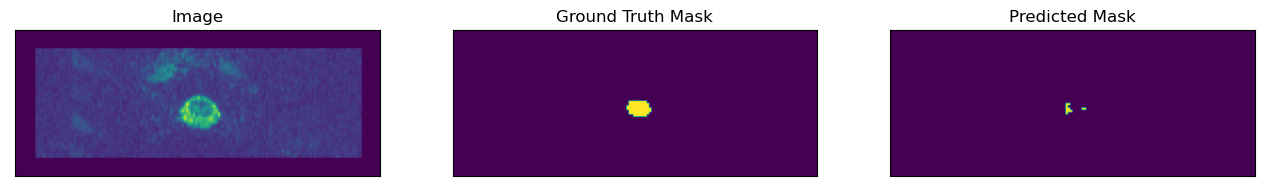

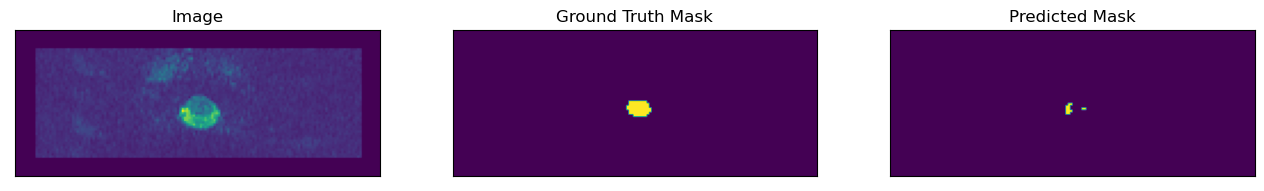

In [10]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(160, 64, 48)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(160,64,48)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160,64,48)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [11]:
created_model = torch.load('../../outputvnet2/vnet3d_best.pth', map_location=torch.device('cpu'))

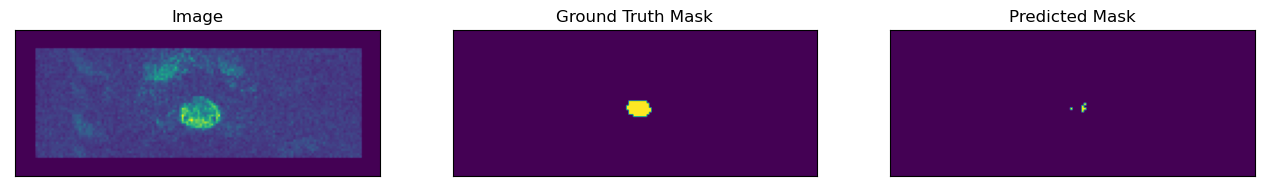

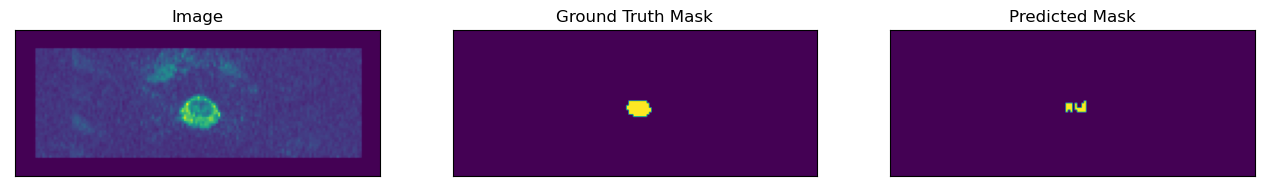

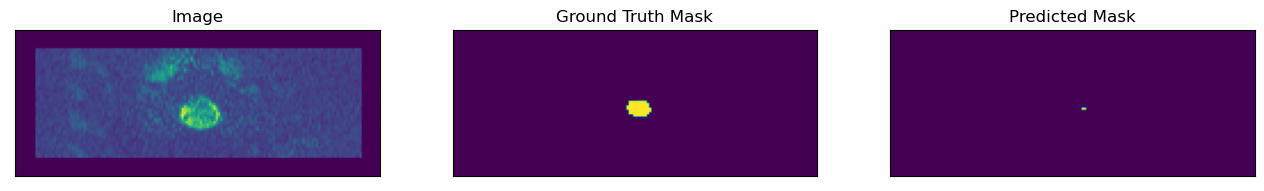

In [12]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(160, 64, 48)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(160,64,48)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160,64,48)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [104]:
dataset = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((144, 48, 32)), tio.CropOrPad((144, 48, 32)))

In [105]:
test_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [10]:
created_model = torch.load('../../outputvnet3pad/vnet3d.pth', map_location=torch.device('cpu'))

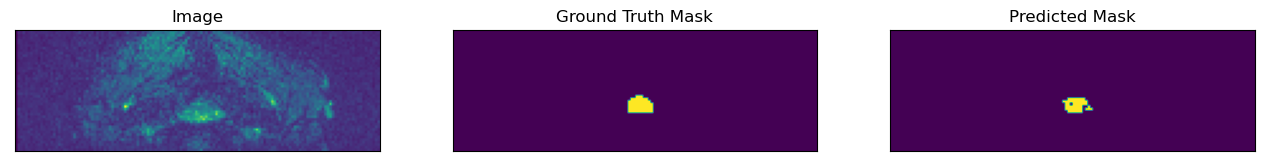

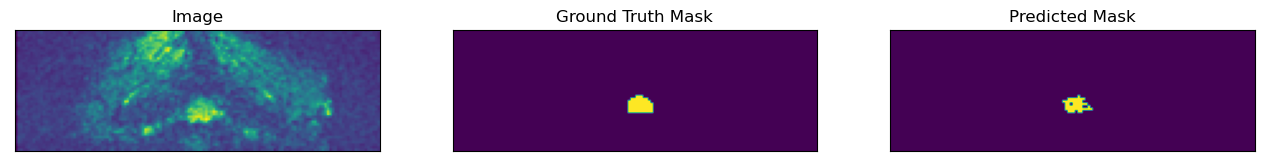

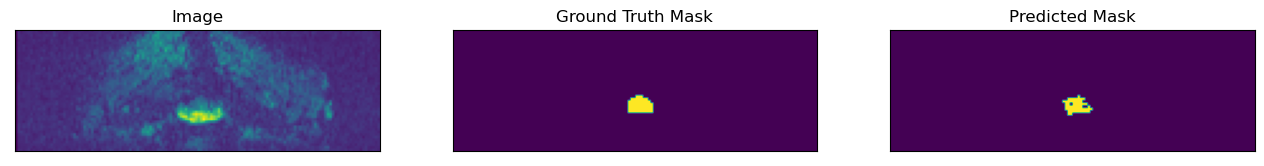

In [21]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [31]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 90/90 [04:43<00:00,  3.15s/it, dice_loss - 0.1109, iou_score - 0.


In [14]:
created_model = torch.load('../../outputvnet4/vnet3d.pth', map_location=torch.device('cpu'))

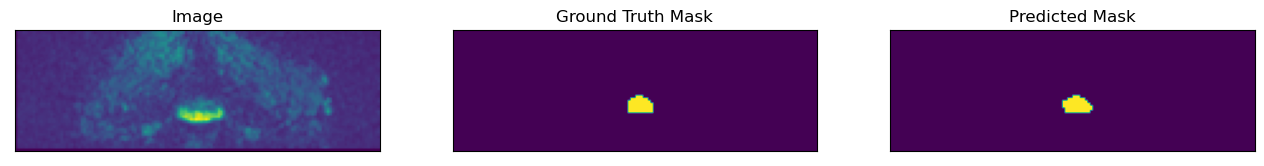

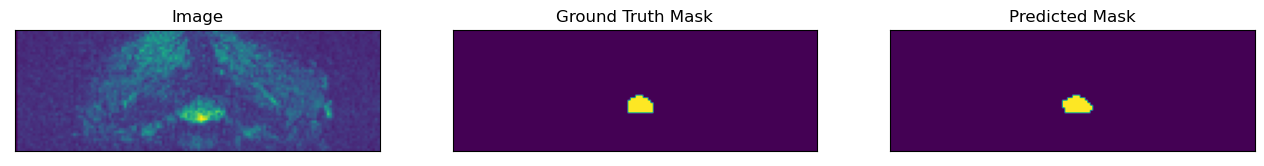

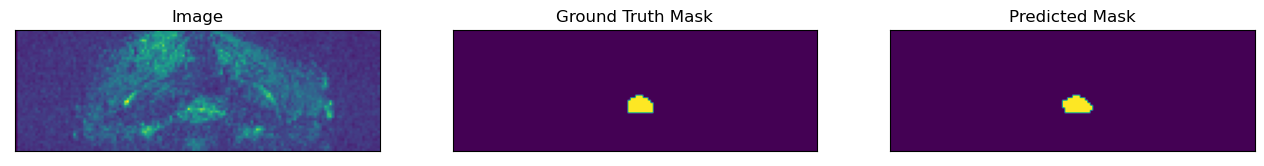

In [10]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [11]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 90/90 [04:39<00:00,  3.11s/it, dice_loss - 0.007137, iou_score - 


In [12]:
logs

{'dice_loss': 0.007137256860733032, 'iou_score': 0.9858259889814588}

In [106]:
image_files = []
image_labels = []
test_images = []
test_labels = []

experiment1 = Path(op.join(sys.path[0], 'dataset/Experiment1'))
experiment2 = Path(op.join(sys.path[0], 'dataset/Experiment2'))
experiment3 = Path(op.join(sys.path[0], 'dataset/Experiment3'))

for file_path in experiment1.iterdir():
    for image in file_path.rglob('*seg.nii.gz'):
        test_images.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        test_labels.append(tio.ScalarImage(label))

for file_path in experiment2.iterdir():
    for image in file_path.rglob('*mean.nii.gz'):
        test_images.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        test_labels.append(tio.ScalarImage(label))

for file_path in experiment3.iterdir():
    for image in file_path.rglob('*seg.nii.gz'):
        test_images.append(tio.ScalarImage(image))
    for label in file_path.rglob('*sc.nii.gz'):
        test_labels.append(tio.ScalarImage(label))

In [55]:
len(test_labels)

47

In [107]:
test_set_old = SpinalCordDataset(test_labels, test_images, tio.CropOrPad((144, 48, 32)), tio.CropOrPad((144, 48, 32)))

In [108]:
test_loader_old = DataLoader(test_set_old, batch_size=1, shuffle=True)

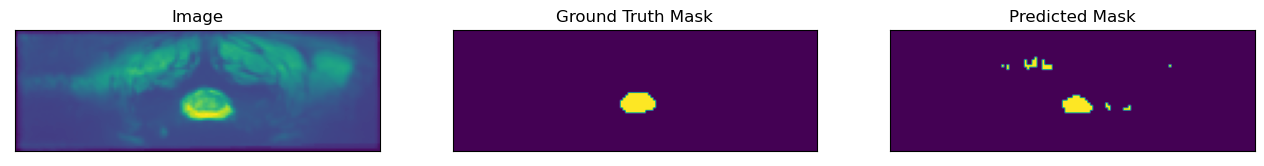

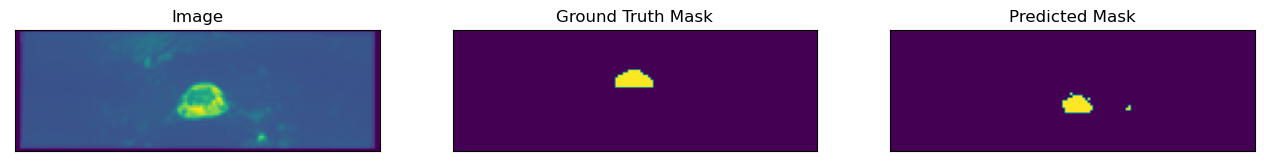

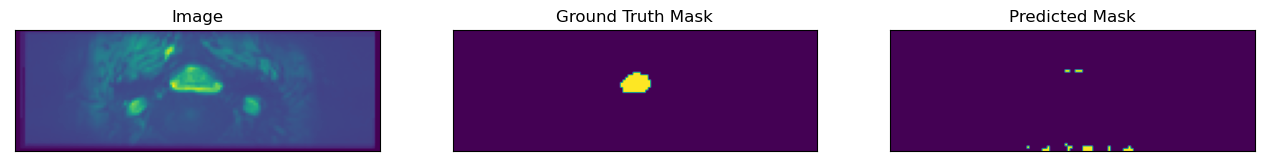

In [16]:
for i in range(3):
    n = np.random.choice(len(dataset_old))
    
    image_vis = dataset_old[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset_old[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [21]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=False
)

logs = test_epoch.run(test_lumbar)

valid: 100%|█| 16/16 [00:10<00:00,  1.57it/s, dice_loss - 0.7218, iou_score - 0.


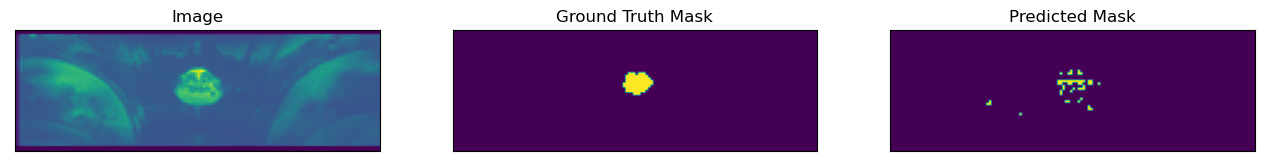

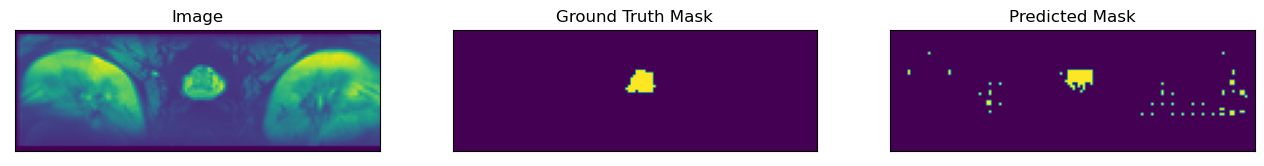

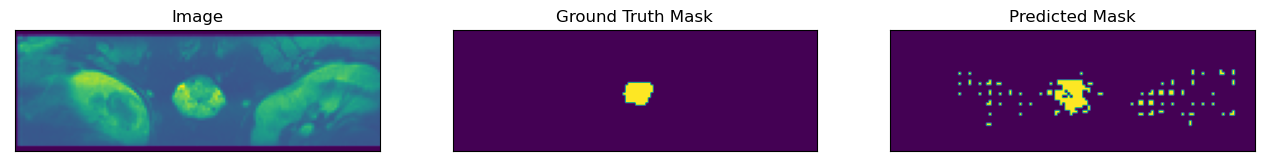

In [13]:
for i in range(3):
    n = np.random.choice(len(lumbar))
    
    image_vis = lumbar[n]['img']['data'].reshape(144, 48, 32)
    image = lumbar[n]['img']['data']
    gt_mask = lumbar[n]['label']['data']
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [17]:
created_model = torch.load('../../unet3d_best.pth', map_location=torch.device('cpu'))

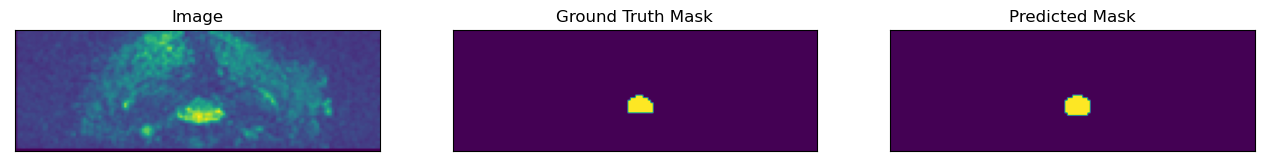

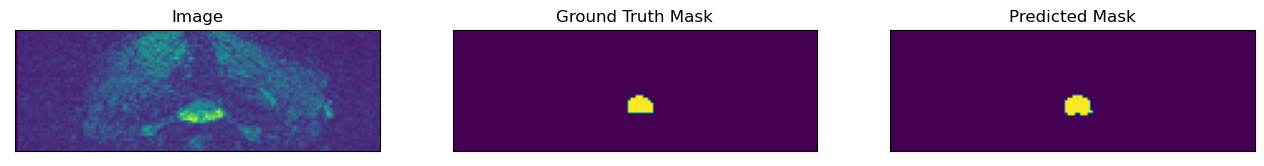

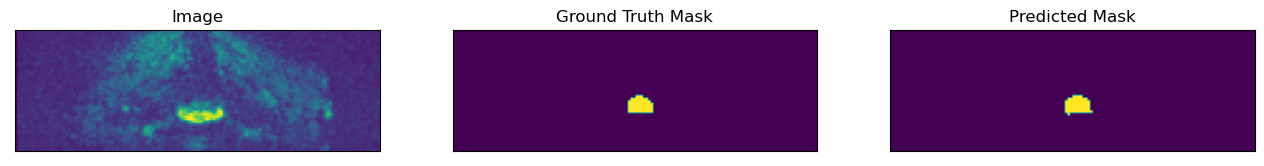

In [15]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

Best V Net

In [12]:
created_model = torch.load('../../outputvnet5/vnet3d.pth', map_location=torch.device('cpu'))

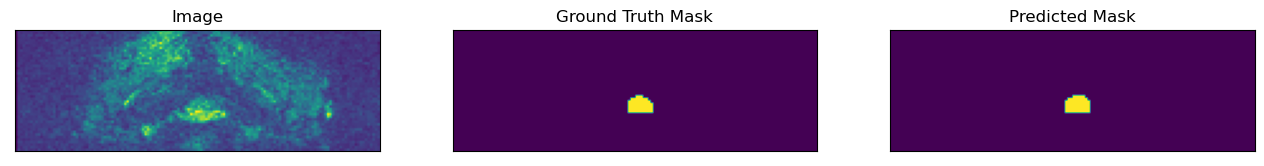

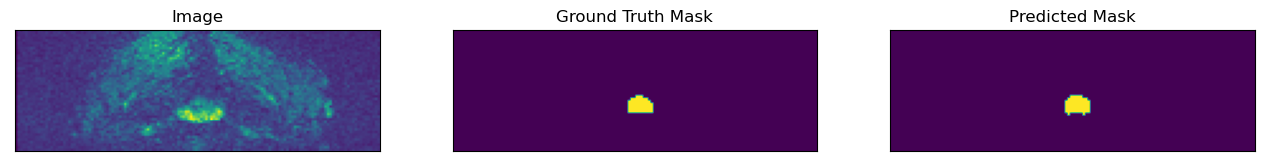

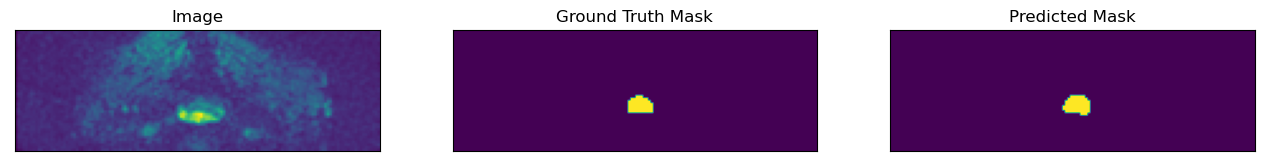

In [16]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [22]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 90/90 [04:40<00:00,  3.11s/it, dice_loss - 0.06303, iou_score - 0


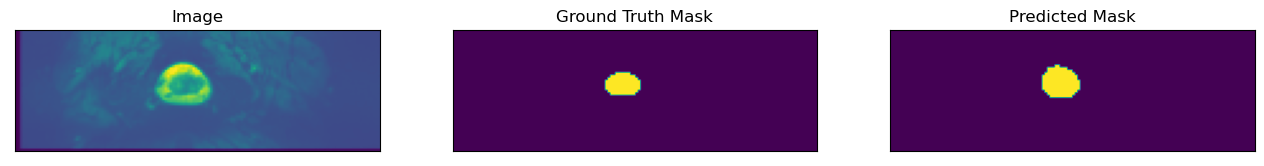

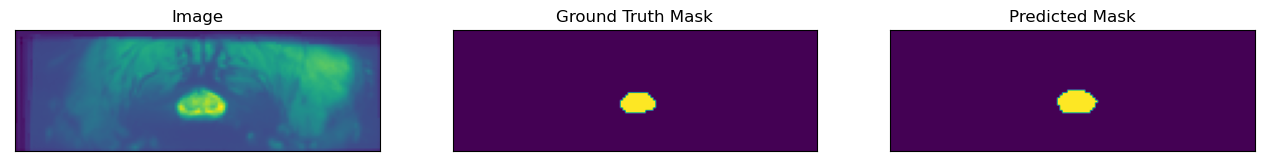

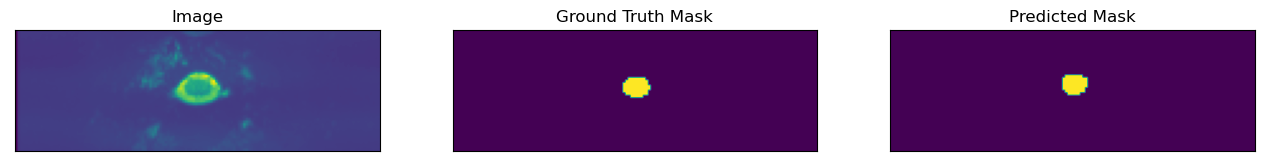

In [61]:
for i in range(3):
    n = np.random.choice(len(test_set_old))
    
    image_vis = test_set_old[n][0].reshape(144, 48, 32)
    image, gt_mask = test_set_old[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [58]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader_old)

valid: 100%|█| 47/47 [00:33<00:00,  1.39it/s, dice_loss - 0.2083, iou_score - 0.


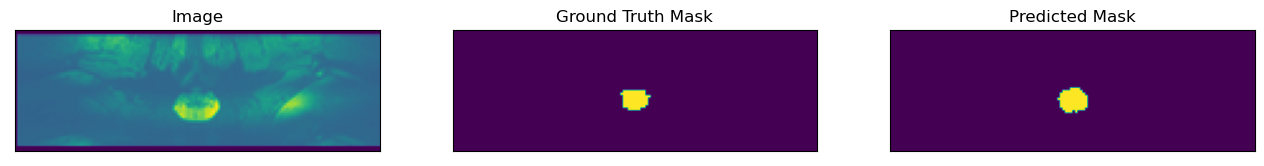

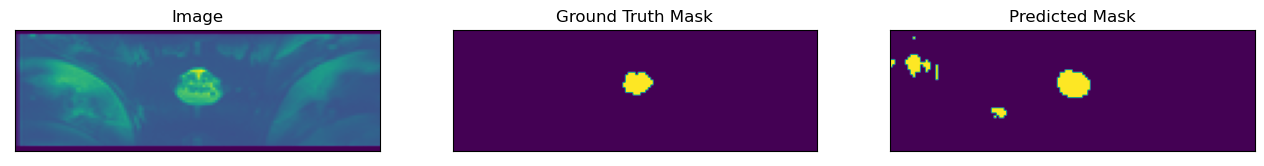

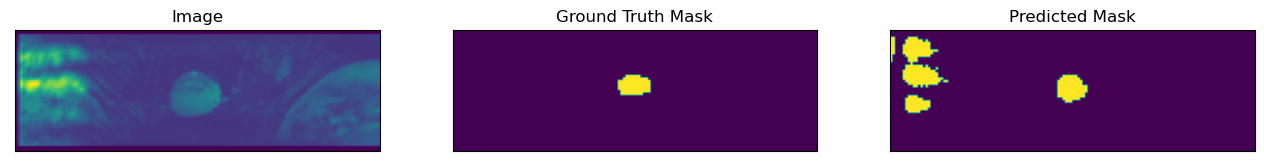

In [21]:
for i in range(3):
    n = np.random.choice(len(lumbar))
    
    image_vis = lumbar[n]['img']['data'].reshape(144, 48, 32)
    image = lumbar[n]['img']['data']
    gt_mask = lumbar[n]['label']['data']
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [23]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=False
)

logs = test_epoch.run(test_lumbar)

valid: 100%|█| 15/15 [00:11<00:00,  1.28it/s, dice_loss - 0.4717, iou_score - 0.


In [116]:
created_model = torch.load('../../outputvnet6/vnet3d_best.pth', map_location=torch.device('cpu'))

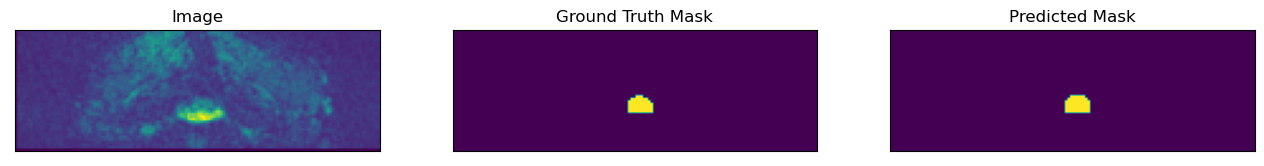

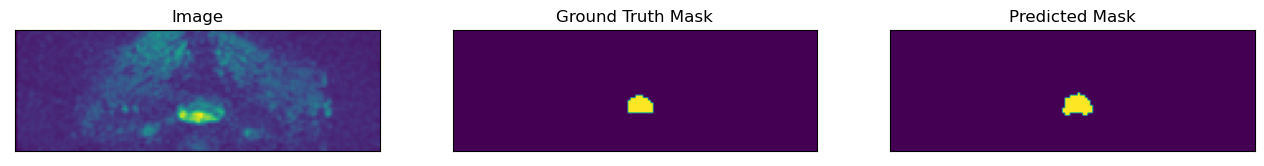

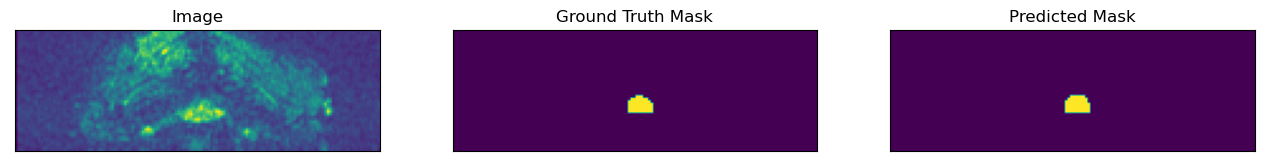

In [117]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [118]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 90/90 [04:48<00:00,  3.21s/it, dice_loss - 0.05134, iou_score - 0


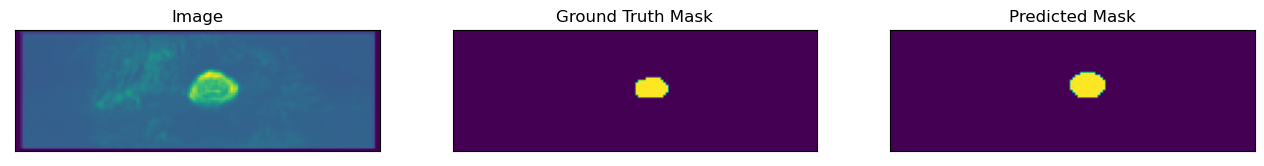

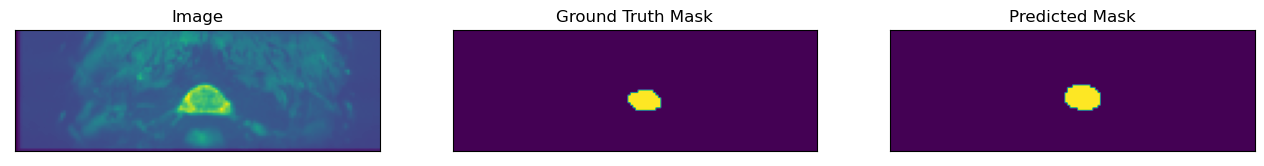

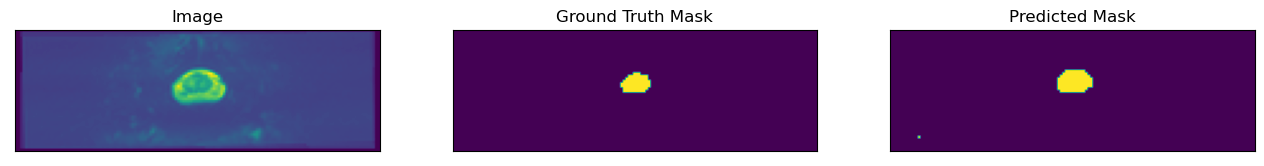

In [119]:
for i in range(3):
    n = np.random.choice(len(test_set_old))
    
    image_vis = test_set_old[n][0].reshape(144, 48, 32)
    image, gt_mask = test_set_old[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [120]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader_old)

valid: 100%|█| 47/47 [00:49<00:00,  1.05s/it, dice_loss - 0.2148, iou_score - 0.


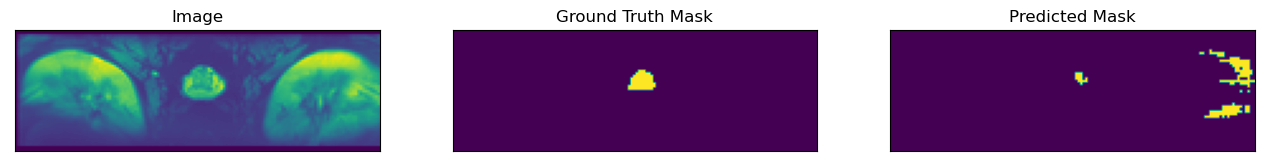

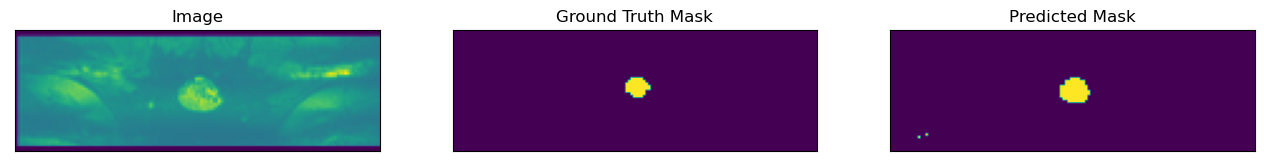

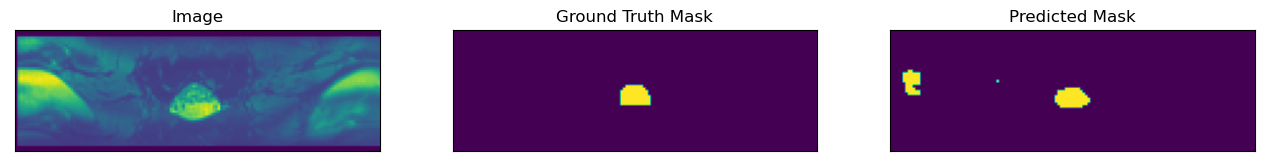

In [123]:
for i in range(3):
    n = np.random.choice(len(lumbar))
    
    image_vis = lumbar[n]['img']['data'].reshape(144, 48, 32)
    image = lumbar[n]['img']['data']
    gt_mask = lumbar[n]['label']['data']
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [122]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=False
)

logs = test_epoch.run(test_lumbar)

valid: 100%|█| 15/15 [00:14<00:00,  1.06it/s, dice_loss - 0.4538, iou_score - 0.


In [62]:
created_model = torch.load('../../outputvnet5/vnet3d_best.pth', map_location=torch.device('cpu'))

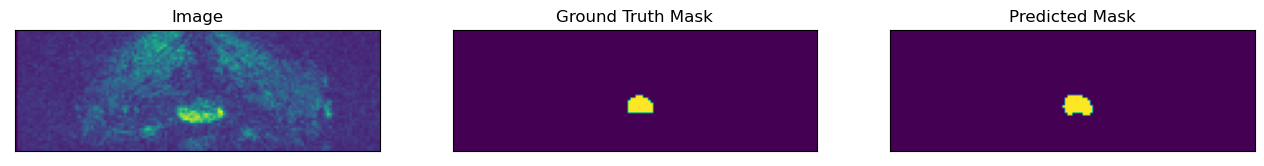

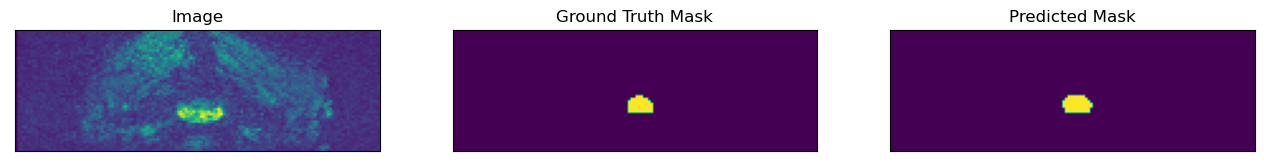

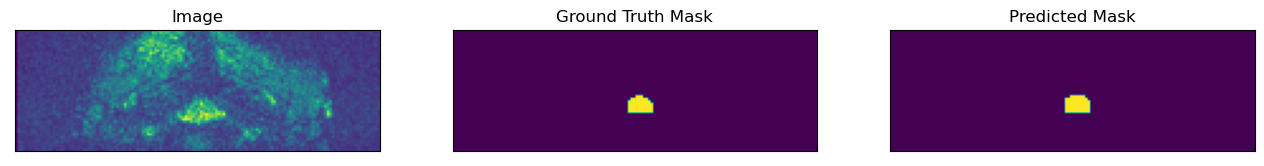

In [63]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [64]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 90/90 [04:28<00:00,  2.98s/it, dice_loss - 0.08, iou_score - 0.85


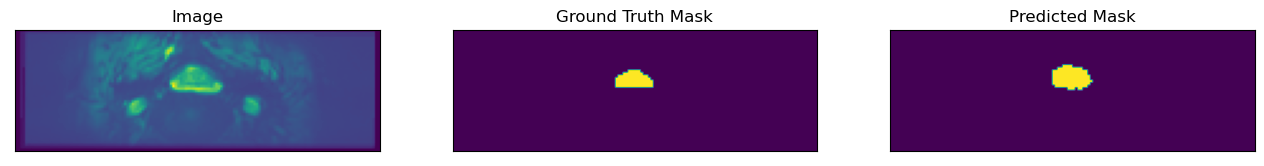

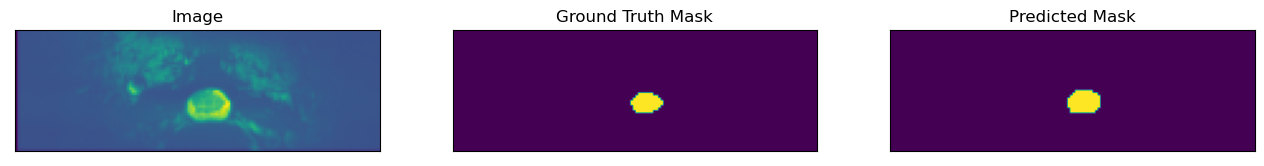

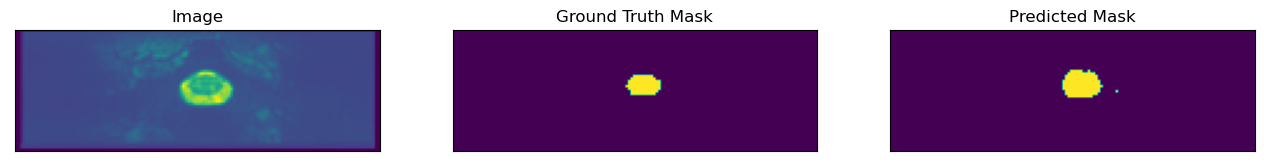

In [65]:
for i in range(3):
    n = np.random.choice(len(test_set_old))
    
    image_vis = test_set_old[n][0].reshape(144, 48, 32)
    image, gt_mask = test_set_old[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [66]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader_old)

valid: 100%|█| 47/47 [00:35<00:00,  1.34it/s, dice_loss - 0.2524, iou_score - 0.


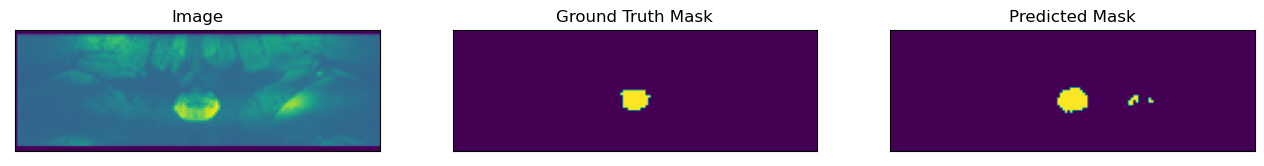

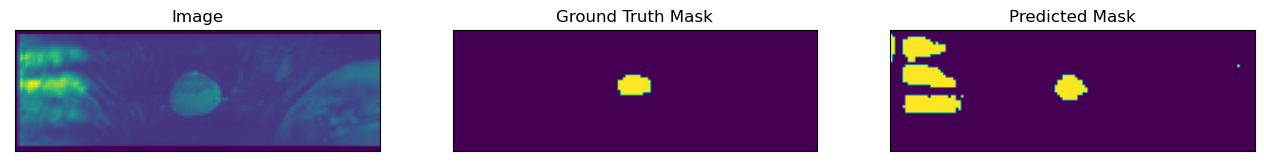

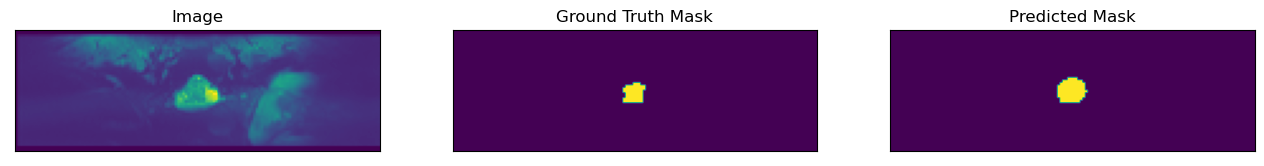

In [67]:
for i in range(3):
    n = np.random.choice(len(lumbar))
    
    image_vis = lumbar[n]['img']['data'].reshape(144, 48, 32)
    image = lumbar[n]['img']['data']
    gt_mask = lumbar[n]['label']['data']
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [68]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=False
)

logs = test_epoch.run(test_lumbar)

valid: 100%|█| 15/15 [00:11<00:00,  1.32it/s, dice_loss - 0.5853, iou_score - 0.


In [73]:
created_model = torch.load('../../outputvnet5/vnet3d_fold4.pth', map_location=torch.device('cpu'))

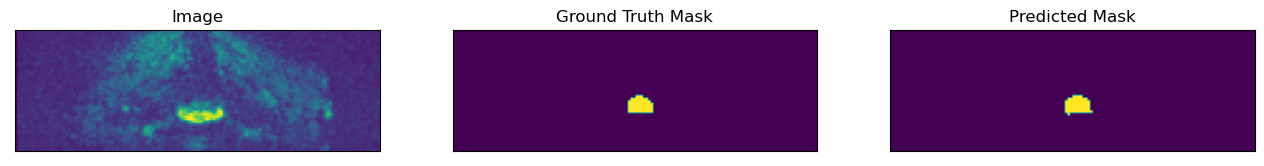

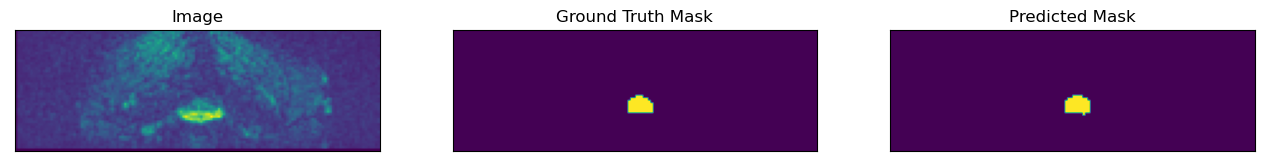

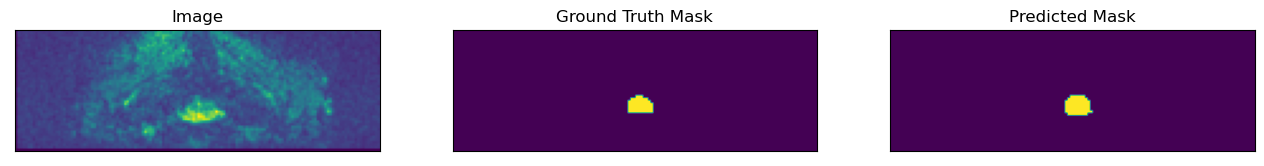

In [74]:
for i in range(3):
    n = np.random.choice(len(dataset))
    
    image_vis = dataset[n][0].reshape(144, 48, 32)
    image, gt_mask = dataset[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [22]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader)

valid: 100%|█| 90/90 [04:40<00:00,  3.11s/it, dice_loss - 0.06303, iou_score - 0


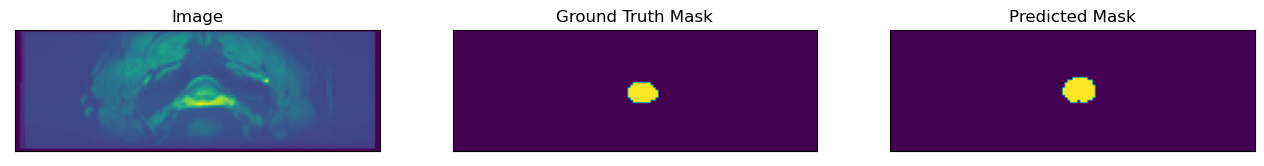

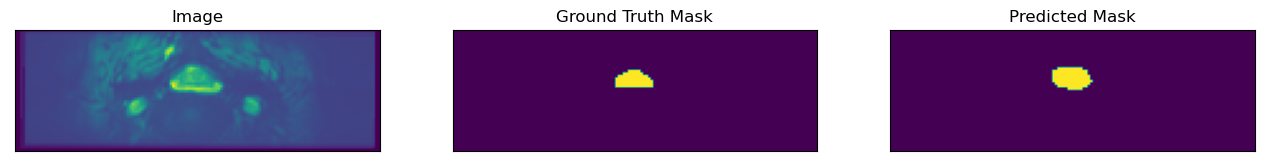

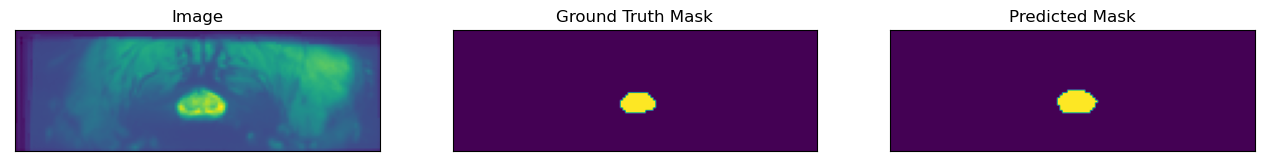

In [75]:
for i in range(3):
    n = np.random.choice(len(test_set_old))
    
    image_vis = test_set_old[n][0].reshape(144, 48, 32)
    image, gt_mask = test_set_old[n]
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [58]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader_old)

valid: 100%|█| 47/47 [00:33<00:00,  1.39it/s, dice_loss - 0.2083, iou_score - 0.


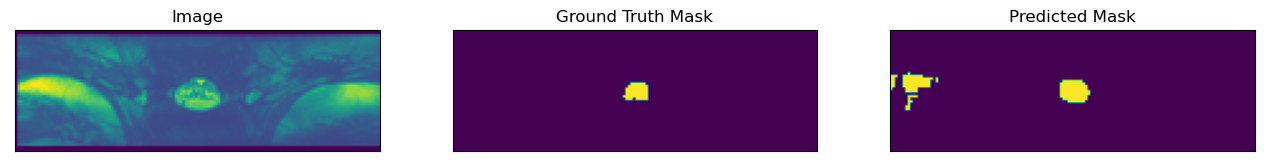

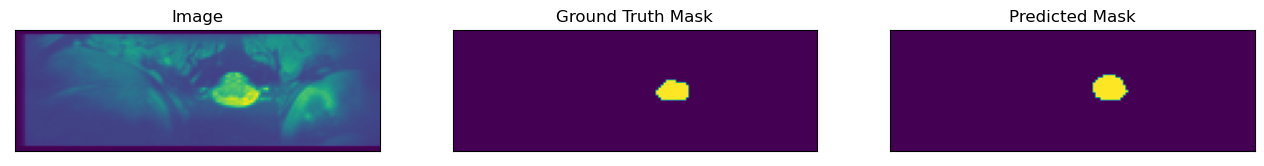

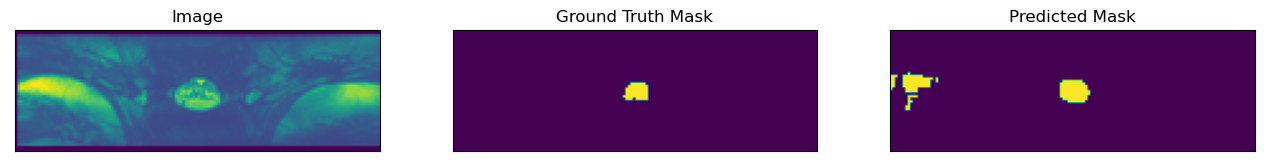

In [80]:
for i in range(3):
    n = np.random.choice(len(lumbar))
    
    image_vis = lumbar[n]['img']['data'].reshape(144, 48, 32)
    image = lumbar[n]['img']['data']
    gt_mask = lumbar[n]['label']['data']
    
    gt_mask = gt_mask.reshape(144, 48, 32)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(144, 48, 32)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [23]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=False
)

logs = test_epoch.run(test_lumbar)

valid: 100%|█| 15/15 [00:11<00:00,  1.28it/s, dice_loss - 0.4717, iou_score - 0.


2D image

In [30]:
created_model = torch.load('../../2dtry/vnet3d_best.pth', map_location=torch.device('cpu'))

In [59]:
dataset_2d = SpinalCordDataset(image_labels, image_files, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))

In [60]:
img = []
lbl = []
for i, j in dataset_2d:
    img.append(i.reshape(1,160,-1))
    lbl.append(j.reshape(1,160,-1))
# dataset_2d.reshape(1,160,-1)
dataset_2d = SpinalCordDataset(lbl, img)

In [58]:
img[0].shape

torch.Size([1, 160, 2240])

In [61]:
test_loader_2d = DataLoader(dataset_2d, batch_size=1, shuffle=True)

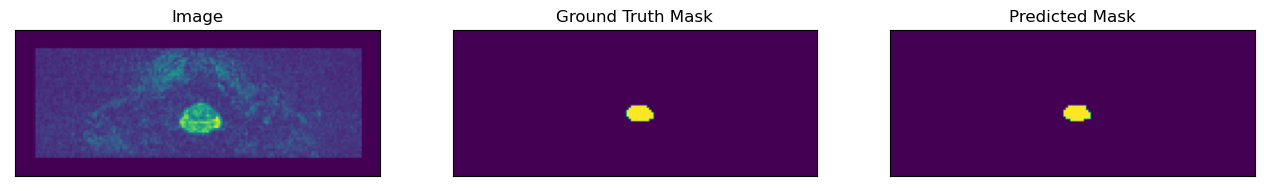

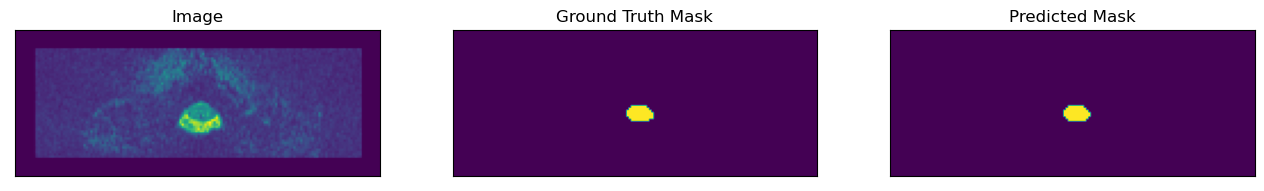

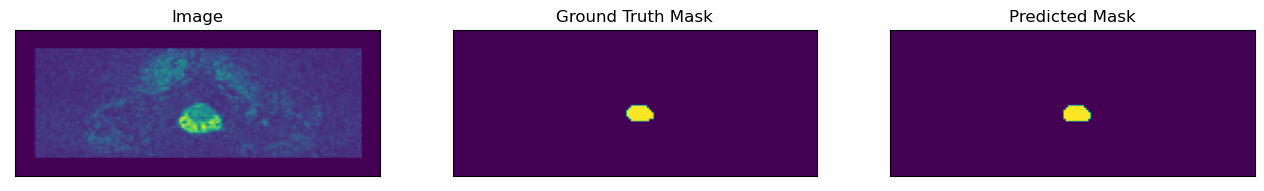

In [34]:
for i in range(3):
    n = np.random.choice(len(dataset_2d))
    
    image_vis = dataset_2d[n][0].reshape(160, 64, 35)
    image, gt_mask = dataset_2d[n]
    image = dataset_2d[n][0].reshape(1,160, -1)
    
    gt_mask = gt_mask.reshape(160, 64, 35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160, 64, 35)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [62]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader_2d)

valid: 100%|█| 360/360 [07:14<00:00,  1.21s/it, dice_loss - 0.02934, iou_score -


In [86]:
test_set_old = SpinalCordDataset(test_labels, test_images, tio.CropOrPad((160, 64, 35)), tio.CropOrPad((160, 64, 35)))
test_loader_old2d = DataLoader(test_set_old, batch_size=1, shuffle=True)

In [87]:
img = []
lbl = []
for i, j in test_loader_old2d:
    img.append(i.reshape(1,160,-1))
    lbl.append(j.reshape(1,160,-1))
# dataset_2d.reshape(1,160,-1)
test_loader_old2d = SpinalCordDataset(lbl, img)
test_loader_old2d = DataLoader(test_loader_old2d, batch_size=1, shuffle=True)

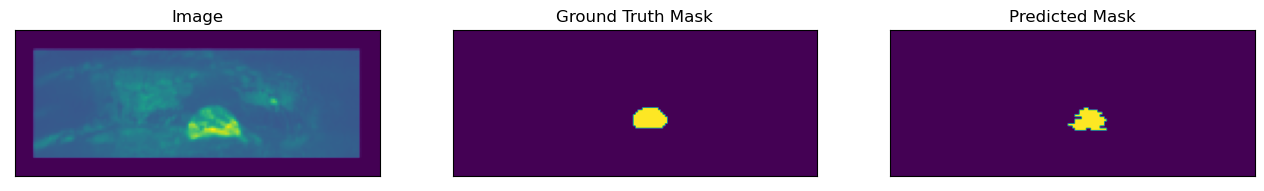

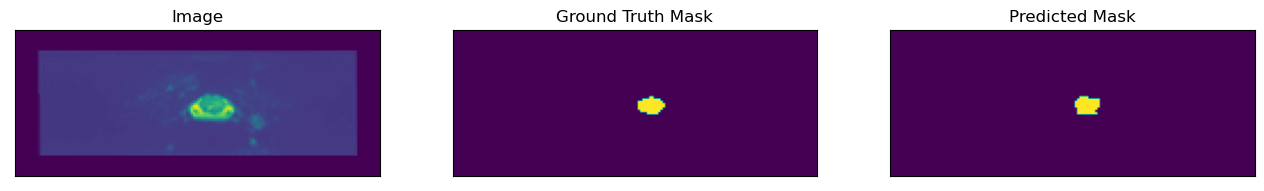

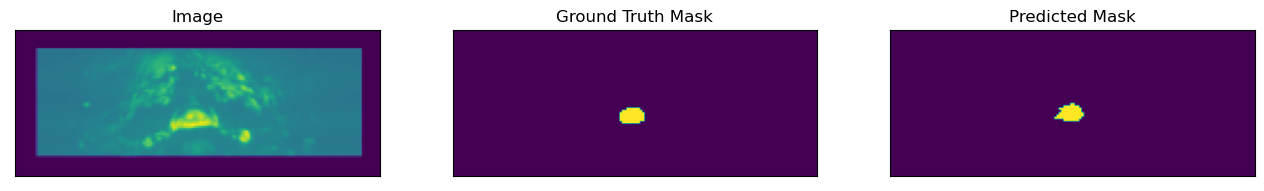

In [68]:
for i in range(3):
    n = np.random.choice(len(test_set_old))
    
    image_vis = test_set_old[n][0].reshape(160, 64, 35)
    image, gt_mask = test_set_old[n]
    image = test_set_old[n][0].reshape(1,160, -1)
    
    gt_mask = gt_mask.reshape(160, 64, 35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160, 64, 35)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [88]:
test_epoch = smpu.train.ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    verbose=True,
)

logs = test_epoch.run(test_loader_old2d)

valid: 100%|█| 47/47 [00:49<00:00,  1.06s/it, dice_loss - 0.1868, iou_score - 0.


In [89]:
subjects = []
cop = tio.CropOrPad((160, 64, 35))

lumbar = Path(op.join(sys.path[0], 'dataset/Lumbar'))

for file_path in lumbar.iterdir():
    for image in file_path.rglob('*mean.nii.gz'):
        image = tio.ScalarImage(image)
    for label in file_path.rglob('*sc.nii.gz'):
        label = tio.ScalarImage(label)
        
    subjects.append(tio.Subject(img=cop(image), label=cop(label), shape=[image.shape]))
    
lumbar = tio.SubjectsDataset(subjects)
test_lumbar = DataLoader(lumbar, batch_size=1, shuffle=True)

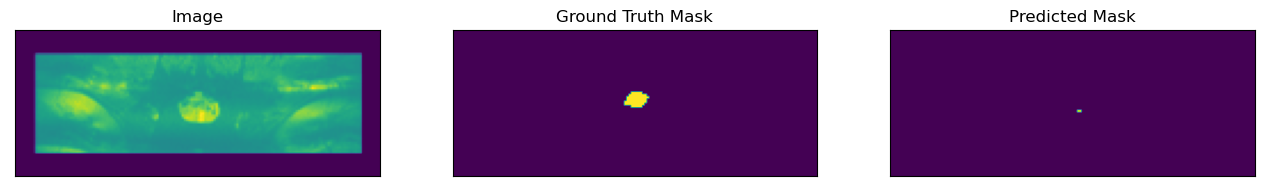

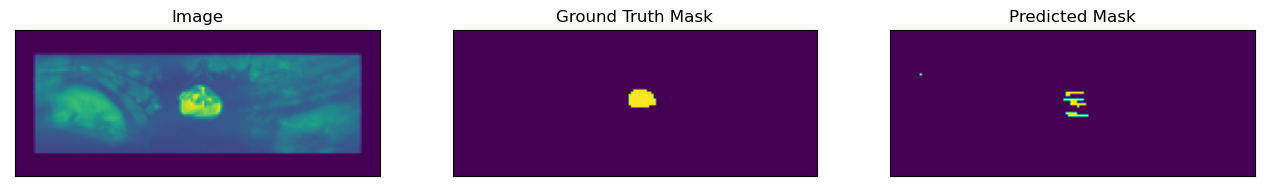

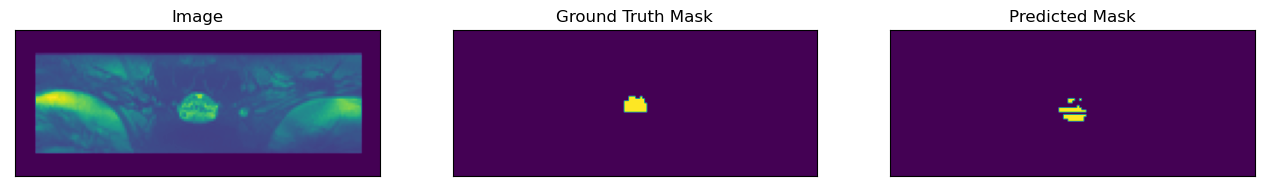

In [91]:
for i in range(3):
    n = np.random.choice(len(lumbar))
    
    image_vis = lumbar[n]['img']['data'].reshape(160, 64, 35)
    image = lumbar[n]['img']['data'].reshape(1,160,-1)
    gt_mask = lumbar[n]['label']['data']
    
    gt_mask = gt_mask.reshape(160, 64, 35)
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    created_model.eval()
    pr_mask = created_model.forward(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round()).reshape(160, 64, 35)
        
    visualize(
        image=image_vis[:,:,12], 
        ground_truth_mask=gt_mask[:,:,12], 
        predicted_mask=pr_mask[:,:,12]
    )

In [92]:
test_epoch = ValidEpoch(
    model=created_model,
    loss=loss,
    metrics=metrics,
    device=torch.device('cpu'),
    unet2d=True
)

logs = test_epoch.run(test_lumbar)

valid: 100%|█| 15/15 [00:14<00:00,  1.07it/s, dice_loss - 0.5335, iou_score - 0.
